# Parallax calculations

In [1]:
import pandas as pd
import numpy as np
import ast, csv, glob
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
%matplotlib inline

### Get the data

The function ```get_sf_surprise()``` in **../logistic/main_experiment.py** produces a number of files recording comparisons between two adjacent 30-year periods. We're interested in **../results/sf1940_forward_surprises.tsv**, which records the differences between a model trained on 1910-39 and one trained on 1940-69, looking in the forward direction. 

In [80]:
surp = pd.read_csv('../results/sf1940_forward_surprises.tsv', sep = '\t')
surp.shape

(513, 8)

Some data munging is required to translate the raw data into a visualizable form. For one thing, we've broken volumes into multiple parts. The predictions for different parts of a volume are going to need to be averaged.

The columns of the data frame are also complicated. The original function ```get_rcc_surprise()``` works with multiple randomly-selected subsets of the data, and compares them to each other. There is no guarantee that a given volume-part will be present on either side of a comparison. So the predicted probabilities for each volume part are aggregated in a dictionary. That dictionary is written to file in its literal form, as a string. We want to aggregate the different predictions for each volume part; to do that, we will need to use ast.literal_eval to turn the string back into a Python dictionary.

First, however, we create a new column with just the volume part of the docid for each volume.

In [81]:
def getvol(adoc):
    return adoc.split('_')[0]

surp = surp.assign(volid = surp.docid.map(getvol))
surp.head()

,docid,diff,original,alien,firstpub,author,tags,title,volid
0,mdp.39015018624778_0,"{'D12811': -0.10444632238296303, 'D1260': -0.3...","{'O17': 0.9999608107717534, 'O29': 0.999996634...","{'A16': 0.9599324011588164, 'A22': 0.976699739...",1953,"Clarke, Arthur C. (Arthur Charles)",sf_oclc,Expedition to Earth : | eleven science-fiction...,mdp.39015018624778
1,uc1.b4094480_0,"{'D12665': -0.44590027233237195, 'D12178': -0....","{'O17': 0.993713666556202, 'O2': 0.87274280041...","{'A16': 0.8609706534120358, 'A22': 0.944917104...",1957,"Wyndham, John",sf_oclc,"The Midwich cuckoos, | $c: by John Wyndham.",uc1.b4094480
2,mdp.39015056246211_1,"{'D1251': 1.2786784505656621, 'D12799': 0.5853...","{'O6': 0.9885778466061584, 'O9': 0.99187004273...","{'A16': 0.41999078334697626, 'A22': 0.43840494...",1958,"Bester, Alfred",sf_loc,Starburst,mdp.39015056246211
3,mdp.39015010321076_1,"{'D12811': 0.024317588009186486, 'D1251': -0.1...","{'O17': 0.9697555496310428, 'O6': 0.2677818791...","{'A16': 0.7158841314936529, 'A22': 0.816507921...",1967,"Davies, L. P. (Leslie Purnell)",sf_oclc|fantasy_oclc,Psychogeist | $c: [by] L. P. Davies.,mdp.39015010321076
4,uc1.b3435509_0,"{'D12591': 0.9170035398163362, 'D12896': 0.325...","{'O26': 0.20514739409567345, 'O14': 0.42581021...","{'A16': 0.22401720562111269, 'A22': 0.10145114...",1962,"Christopher, John",sf_oclc,The world in winter,uc1.b3435509


### Exploratory analysis

Just understanding the patterns in the data.

In [98]:
originals = []
aliens = []

for idx, row in surp.iterrows():
    if 'sf' not in row.tags and 'bailey' not in row.tags:
        continue
        # because we're not interested in visualizing the random
        # contrast set

    orig = ast.literal_eval(row['original'])
    alien = ast.literal_eval(row['alien'])
    originals.append(len(set(orig.values())))
    aliens.append(len(set(alien.values())))
    if len(orig) != len(set(orig.values())):
        print('not equal')
    if len(alien) != len(set(alien.values())):
        print('not equal')
    
print(sum(originals)/len(originals))
print(sum(aliens) / len(aliens))

11.450381679389313
30.0


### Some complicated shit that didn't end up getting used

I really don't remember why I thought it might be necessary to weight different models ... oh yeah, I thought some models might be less regularized and would have more extreme values than others, and they might need to be downweighted. So I created a complex way of doing that using inverse variances. None of that ended up being used. If you check out ```figure3.R```, you'll see we plot the unweighted means.

In [83]:
values = dict()
for docid, row in surp.iterrows():
    probdict = ast.literal_eval(row.original)
    for k, v in probdict.items():
        if k not in values:
            values[k] = []
        values[k].append(v)
    
    probdict = ast.literal_eval(row.alien)
    for k, v in probdict.items():
        if k not in values:
            values[k] = []
        values[k].append(v)
        
inverse_variances = dict()
for k, v in values.items():
    inverse_variances[k] = 1 / np.var(v)

In [84]:
def weighted_stats(observations, inverse_variances):
    vals = []
    weights = []
    for k, v in observations:
        vals.append(v)
        weights.append(inverse_variances[k])
    
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    vals = np.array(vals)
    
    stats = DescrStatsW(vals, weights=weights)
    
    return stats.mean, stats.std       

### The section where the data transformation actually takes place

We group volume parts by volume ID, and calculate mean prewar and postwar predictions for each volume. We also calculate a weighted value. These ended up not being very different.


In [85]:
fieldnames = ['volid', 'author', 'title', 'firstpub', 'prewarmean', 'postwarmean',
              'unweightpremean', 'unweightpostmean',
              'prestd', 'poststd', 'diff', 'ttest', 'pval']

with open('1940surprises.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('\t'.join(fieldnames) + '\n')
    
for volid, df in surp.groupby('volid'):
    df.reset_index(inplace = True)
    tags = df.loc[0, 'tags']
    if 'sf_loc' in tags or 'sf_oclc' in tags or 'bailey' in tags:
        prewartuples = []
        postwartuples = []
        prevals = []
        postvals = []
        
        for idx, row in df.iterrows():
            prewar = ast.literal_eval(row.alien)
            postwar = ast.literal_eval(row.original)
            for k, v in prewar.items():
                prewartuples.append((k, v))
                prevals.append(v)
            for k, v in postwar.items():
                postwartuples.append((k, v))
                postvals.append(v)
                
        premean, prestd = weighted_stats(prewartuples, inverse_variances)
        postmean, poststd = weighted_stats(postwartuples, inverse_variances)
        
        unweightpremean = np.mean(prevals)
        unweightpostmean = np.mean(postvals)
        
        statistic, pvalue = ttest_ind(prevals, postvals, equal_var = False)
        o = dict()
        o['volid'] = volid
        o['title'] = df.loc[0, 'title']
        o['author'] = df.loc[0, 'author']
        o['firstpub'] = df.loc[0, 'firstpub']
        o['prewarmean'] = premean
        o['postwarmean'] = postmean
        o['unweightpremean'] = unweightpremean
        o['unweightpostmean'] = unweightpostmean
        o['diff'] = postmean - premean
        o['prestd'] = np.std(prevals)
        o['poststd'] = np.std(postvals)
        o['ttest'] = statistic
        o['pval'] = pvalue
        with open('1940surprises.tsv', mode = 'a', encoding = 'utf-8') as f:
            writer = csv.DictWriter(f, delimiter = '\t', fieldnames = fieldnames)
            writer.writerow(o)
        

#### filtering the data

Now there's a complex folderol which I believe is about a) primarily filtering the data, using an earlier (manually-winnowed) version of the data as a guide and b) inheriting the 'colour' column from an earlier version of the data. The colour defines which volumes are printed in black and labeled.

In [86]:
old = pd.read_csv('../results/sf1940_means.tsv', sep = '\t')
old.shape

(19, 8)

In [87]:
new = pd.read_csv('../interpretations/1940surprises.tsv', sep = '\t', index_col = 'volid')

In [88]:
new.shape

(118, 12)

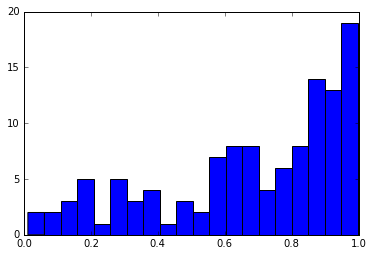

In [89]:
plt.hist(new.unweightpremean, bins = 20)
plt.show()

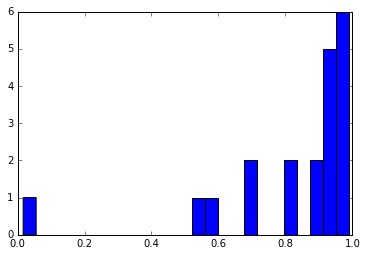

In [102]:
plt.hist(new.unweightpostmean, bins = 25)
plt.show()

In [91]:
keepers = set(old.volid)
keepers.add('uc1.$b102273')

In [92]:
new = new[new.index.isin(keepers)]

**Filtering step there.**

In [93]:
new.shape

(20, 12)

In [94]:
old.set_index('volid', inplace = True)
new = new.assign(colour = old['colour'])

In [95]:
new.loc['uc1.$b102273', 'colour'] = 'gray'

#### actually write data to file

In [96]:
new.to_csv('1940plotarrows.tsv', index_label = 'volid', sep = '\t')

In [86]:
new.head()

,author,title,firstpub,prewarmean,postwarmean,prestd,poststd,diff,ttest,pval,colour
volid,,,,,,,,,,,
mdp.39015008724802,"Merril, Judith",SF; the best of the best.,1967,0.415794,0.690476,0.140296,0.075441,0.274682,-9.450210,2.877652e-11,black
mdp.39015066050850,"Vonnegut, Kurt",Player piano.,1952,0.367623,0.512169,0.161752,0.032036,0.144546,-8.376448,1.463180e-09,black
mdp.39015003922005,"Heinlein, Robert A. (Robert Anson)",Stranger in a strange land.,1961,0.221000,0.505439,0.165838,0.001557,0.284438,-6.824835,1.403550e-06,black
mdp.39015020680917,"Simak, Clifford D",Way station,1963,0.556094,0.969216,0.104968,0.046781,0.413123,-6.737414,1.262753e-07,gray
mdp.39015052467530,"Le Guin, Ursula K",The left hand of darkness,1969,0.525780,0.778591,0.042151,0.055449,0.252811,-6.432946,5.632682e-07,black


In [83]:
old.colour

0     black
1     black
2      gray
3      gray
4      gray
5     black
6      gray
7      gray
8     black
9      gray
10     gray
11     gray
12     gray
13     gray
14     gray
15     gray
16     gray
17    black
18     gray
Name: colour, dtype: object

In [84]:
old.head()

,index,volid,diff,alien,original,firstpub,colour,author,title
0,0,mdp.39015003922005,0.994679,0.407836,0.616718,1961,black,"Heinlein, Robert A. (Robert Anson)",Stranger in a strange land.
1,1,mdp.39015008724802,0.968220,0.444707,0.648033,1967,black,"Merril, Judith",SF; the best of the best.
2,2,mdp.39015007043006,0.709593,0.594200,0.743215,1942,gray,"Heinlein, Robert A. (Robert Anson)",Beyond this horizon.
3,3,mdp.39015029750877,0.704114,0.564932,0.712796,1954,gray,"Hubbard, L. Ron (La Fayette Ron)",Return to tomorrow
4,4,mdp.39015003498436,0.673311,0.425605,0.567000,1965,gray,NaN,The Magazine of fantasy and science fiction : ...
